https://stackoverflow.com/questions/51903350/python-vs-matlab-performance-on-algorithm

First we measure the scaling of the serial implementation

_Performance enhancement 1_: use Numba within a single array

In [1]:
!hostname

d89b6d786b66


In [2]:
import numpy as np
import time
import matplotlib.pyplot as plt

In [39]:
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [3]:
# https://github.com/nikdon/pyEntropy
def sample_entropy(time_series, sample_length, tolerance=None):
    """Calculate and return Sample Entropy of the given time series.
    Distance between two vectors defined as Euclidean distance and can
    be changed in future releases
    Args:
        time_series: Vector or string of the sample data
        sample_length: Number of sequential points of the time series
        tolerance: Tolerance (default = 0.1...0.2 * std(time_series))
    Returns:
        Vector containing Sample Entropy (float)
    References:
        [1] http://en.wikipedia.org/wiki/Sample_Entropy
        [2] http://physionet.incor.usp.br/physiotools/sampen/
        [3] Madalena Costa, Ary Goldberger, CK Peng. Multiscale entropy analysis
            of biological signals
    """
    if tolerance is None:
        tolerance = 0.1 * np.std(time_series)

    n = len(time_series)
    prev = np.zeros(n)
    curr = np.zeros(n)
    A = np.zeros((sample_length, 1))  # number of matches for m = [1,...,template_length - 1]
    B = np.zeros((sample_length, 1))  # number of matches for m = [1,...,template_length]

    for i in range(n - 1):
        nj = n - i - 1
        ts1 = time_series[i]
        for jj in range(nj):
            j = jj + i + 1
            if abs(time_series[j] - ts1) < tolerance:  # distance between two vectors
                curr[jj] = prev[jj] + 1
                temp_ts_length = min(sample_length, curr[jj])
                for m in range(int(temp_ts_length)):
                    A[m] += 1
                    if j < n - 1:
                        B[m] += 1
            else:
                curr[jj] = 0
        for j in range(nj):
            prev[j] = curr[j]

    N = n * (n - 1) / 2
    B = np.vstack(([N], B[:sample_length - 1]))
    similarity_ratio = A / B
    se = - np.log(similarity_ratio)
    se = np.reshape(se, -1)
    return se

## function profiling

Conclusion: Most of the time is spent in "sample_entropy"

In [2]:
a = np.random.rand(1, 100)[0]

%prun -s cumtime sample_entropy(a, 4, 0.1 * np.std(a))

NameError: name 'np' is not defined

## line profiling

Once we know that the majority of time is spent in "Sample entropy", investigate which lines are consuming most of the CPU time

https://ipython-books.github.io/43-profiling-your-code-line-by-line-with-line_profiler/

In [5]:
!pip install line_profiler

In [6]:
%load_ext line_profiler

In [7]:
a = np.random.rand(1, 100)[0]

%lprun -f sample_entropy sample_entropy(a, 4, 0.1 * np.std(a))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in log


Timer unit: 1e-06 s

Total time: 0.642446 s
File: <ipython-input-3-f82a0bee80af>
Function: sample_entropy at line 2

Line #      Hits         Time  Per Hit   % Time  Line Contents
     2                                           def sample_entropy(time_series, sample_length, tolerance=None):
     3                                               """Calculate and return Sample Entropy of the given time series.
     4                                               Distance between two vectors defined as Euclidean distance and can
     5                                               be changed in future releases
     6                                               Args:
     7                                                   time_series: Vector or string of the sample data
     8                                                   sample_length: Number of sequential points of the time series
     9                                                   tolerance: Tolerance (default = 0.1...0.2 * s

## scaling of serial function

In [8]:
num_tests=3
serial_original_timing_dict={}
serial_original_reslt_dict={}
for arry_size in [100,1000,5000,10000]:
    reslt_ary=[]
    for test_indx in range(num_tests):
        a = np.random.rand(1, arry_size)[0]
        start_time = time.time()
        outp=sample_entropy(a, 4, 0.1 * np.std(a))
        elapsed_time = time.time() - start_time
        serial_original_reslt_dict[(arry_size,test_indx)]=outp
        print(arry_size,':',elapsed_time,'seconds')
        reslt_ary.append(elapsed_time)
    serial_original_timing_dict[arry_size]=sum(reslt_ary)/num_tests

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in log


100 : 0.030996322631835938 seconds
100 : 0.009676218032836914 seconds
100 : 0.012649059295654297 seconds
1000 : 1.005979299545288 seconds
1000 : 1.0840840339660645 seconds
1000 : 1.466383695602417 seconds
5000 : 27.92833161354065 seconds
5000 : 24.59664559364319 seconds
5000 : 24.65927290916443 seconds
10000 : 102.77713131904602 seconds
10000 : 126.23881030082703 seconds
10000 : 113.91043543815613 seconds


In [9]:
serial_original_timing_dict

{100: 0.017773866653442383,
 1000: 1.185482343037923,
 5000: 25.72808337211609,
 10000: 114.30879235267639}

In [10]:
x,y=zip(*serial_original_timing_dict.items())

In [11]:
z = np.polyfit(x, y, 2)
f = np.poly1d(z)
print(f)
x_new = np.linspace(0, 10000, 50)
y_new = f(x_new)

          2
1.26e-06 x - 0.001227 x + 0.5644


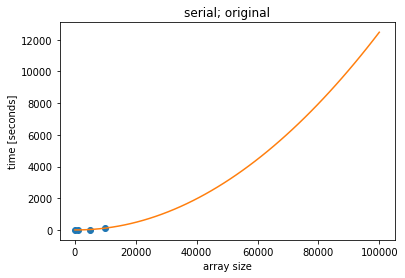

In [12]:
_=plt.plot(x,y,'o', x_new, y_new)
#plt.scatter(x,y)
plt.ylabel('time [seconds]')
plt.xlabel('array size')
plt.title('serial; original')
plt.show()

# lambda to replace for loop

as faras I understand, in order to use joblib, need to change the for loop to a generator:<BR>
https://joblib.readthedocs.io/en/latest/parallel.html#parallel<BR>
"The core idea is to write the code to be executed as a generator expression, and convert it to parallel computing"
    
According to line profiling, 30% of time is spent in a for loop that could be converted to a lambda function. Let's see what the performance enhancement is due to that change

In [13]:
# https://github.com/nikdon/pyEntropy
def sample_entropy(time_series, sample_length, tolerance=None):
    """Calculate and return Sample Entropy of the given time series.
    Distance between two vectors defined as Euclidean distance and can
    be changed in future releases
    Args:
        time_series: Vector or string of the sample data
        sample_length: Number of sequential points of the time series
        tolerance: Tolerance (default = 0.1...0.2 * std(time_series))
    Returns:
        Vector containing Sample Entropy (float)
    References:
        [1] http://en.wikipedia.org/wiki/Sample_Entropy
        [2] http://physionet.incor.usp.br/physiotools/sampen/
        [3] Madalena Costa, Ary Goldberger, CK Peng. Multiscale entropy analysis
            of biological signals
    """
    if tolerance is None:
        tolerance = 0.1 * np.std(time_series)

    n = len(time_series)
    prev = np.zeros(n)
    curr = np.zeros(n)
    A = np.zeros((sample_length, 1))  # number of matches for m = [1,...,template_length - 1]
    B = np.zeros((sample_length, 1))  # number of matches for m = [1,...,template_length]

    for i in range(n - 1):
        nj = n - i - 1
        ts1 = time_series[i]
        for jj in range(nj):
            j = jj + i + 1
            if abs(time_series[j] - ts1) < tolerance:  # distance between two vectors
                curr[jj] = prev[jj] + 1
                temp_ts_length = min(sample_length, curr[jj])
                for m in range(int(temp_ts_length)):
                    A[m] += 1
                    if j < n - 1:
                        B[m] += 1
            else:
                curr[jj] = 0
#        for j in range(nj):
#            prev[j] = curr[j]
        prev = [curr[j] for j in range(nj)]

    N = n * (n - 1) / 2
    B = np.vstack(([N], B[:sample_length - 1]))
    similarity_ratio = A / B
    se = - np.log(similarity_ratio)
    se = np.reshape(se, -1)
    return se

In [14]:
a = np.random.rand(1, 100)[0]
%lprun -f sample_entropy sample_entropy(a, 4, 0.1 * np.std(a))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in log


Timer unit: 1e-06 s

Total time: 0.392972 s
File: <ipython-input-13-adbe2aa07d5b>
Function: sample_entropy at line 2

Line #      Hits         Time  Per Hit   % Time  Line Contents
     2                                           def sample_entropy(time_series, sample_length, tolerance=None):
     3                                               """Calculate and return Sample Entropy of the given time series.
     4                                               Distance between two vectors defined as Euclidean distance and can
     5                                               be changed in future releases
     6                                               Args:
     7                                                   time_series: Vector or string of the sample data
     8                                                   sample_length: Number of sequential points of the time series
     9                                                   tolerance: Tolerance (default = 0.1...0.2 * 

In [15]:
num_tests=3
serial_lambda_timing_dict={}
serial_lambda_reslt_dict={}
for arry_size in [100,1000,5000,10000]:
    reslt_ary=[]
    for test_indx in range(num_tests):
        a = np.random.rand(1, arry_size)[0]
        start_time = time.time()
        outp=sample_entropy(a, 4, 0.1 * np.std(a))
        elapsed_time = time.time() - start_time
        serial_lambda_reslt_dict[(arry_size,test_indx)]=outp
        print(arry_size,':',elapsed_time,'seconds')
        reslt_ary.append(elapsed_time)
    serial_lambda_timing_dict[arry_size]=sum(reslt_ary)/num_tests

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in log
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


100 : 0.03336048126220703 seconds
100 : 0.01607680320739746 seconds
100 : 0.013380289077758789 seconds
1000 : 0.9666922092437744 seconds
1000 : 0.9244775772094727 seconds
1000 : 1.1754088401794434 seconds
5000 : 29.00029468536377 seconds
5000 : 27.27799940109253 seconds
5000 : 30.314775943756104 seconds
10000 : 106.91291642189026 seconds
10000 : 94.9902024269104 seconds
10000 : 96.87069606781006 seconds


In [46]:
serial_lambda_timing_dict

{100: 0.020939191182454426,
 1000: 1.0221928755442302,
 5000: 28.86435667673747,
 10000: 99.59127163887024}

--> Slightly faster, but not significant

In [41]:
x,y=zip(*serial_lambda_timing_dict.items())

In [42]:
z = np.polyfit(x, y, 2)
f = np.poly1d(z)
print(f)
x_new = np.linspace(0, 10000, 50)
y_new = f(x_new)

          2
8.34e-07 x + 0.001698 x - 0.7335


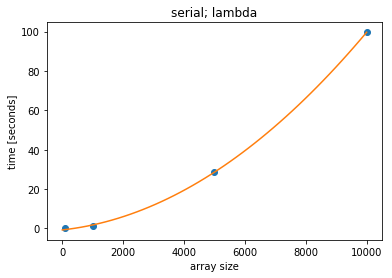

In [43]:
_=plt.plot(x,y,'o', x_new, y_new)
#plt.scatter(x,y)
plt.ylabel('time [seconds]')
plt.xlabel('array size')
plt.title('serial; lambda')
plt.show()

## compare output of original and lambda-based

--> I don't know how to interpret the outputs, so I don't know whether the comparisons are acceptable

In [45]:
serial_original_reslt_dict

{(100, 0): array([ 2.93879835,  2.98801023,         inf,         nan]),
 (100, 1): array([ 2.81341072,  3.10493157,         inf,         nan]),
 (100, 2): array([ 2.69301232,  2.4941233 ,  2.60268969,         inf]),
 (1000, 0): array([ 2.895973  ,  2.8638716 ,  2.86828187,  3.09104245]),
 (1000, 1): array([ 2.86384387,  2.82004354,  2.8492899 ,  2.63905733]),
 (1000, 2): array([ 2.86048064,  2.80648423,  2.80394296,  3.54577861]),
 (5000, 0): array([ 2.86775559,  2.87866134,  2.89260555,  2.88811085]),
 (5000, 1): array([ 2.86738533,  2.87168713,  2.89438728,  2.87694874]),
 (5000, 2): array([ 2.86971897,  2.86578518,  2.84435906,  2.78330694]),
 (10000, 0): array([ 2.86271106,  2.86642089,  2.86533693,  2.91555649]),
 (10000, 1): array([ 2.86521402,  2.86600525,  2.86511134,  2.8918897 ]),
 (10000, 2): array([ 2.87205874,  2.87702985,  2.88413512,  2.86507081])}

In [44]:
serial_lambda_reslt_dict

{(100, 0): array([ 2.7080502 ,  2.62969689,  3.13549422,         inf]),
 (100, 1): array([ 2.92364655,  2.72361472,         inf,         nan]),
 (100, 2): array([ 2.87235325,  3.19309171,         inf,         nan]),
 (1000, 0): array([ 2.85848906,  2.87623688,  2.92839915,  3.35573501]),
 (1000, 1): array([ 2.89098456,  2.87339123,  2.87446305,  1.99243016]),
 (1000, 2): array([ 2.85786096,  2.84597925,  2.68658247,  2.78147767]),
 (5000, 0): array([ 2.86072028,  2.85088122,  2.86187409,  2.88403861]),
 (5000, 1): array([ 2.86526779,  2.86919733,  2.87546923,  2.90989323]),
 (5000, 2): array([ 2.86305662,  2.86938197,  2.86455222,  2.93924866]),
 (10000, 0): array([ 2.86367111,  2.86116112,  2.85210227,  2.81656736]),
 (10000, 1): array([ 2.86235601,  2.86056957,  2.86593423,  2.8374139 ]),
 (10000, 2): array([ 2.86374367,  2.86245601,  2.86552734,  2.87200302])}

# fine-grain concurrency: Numba
### Numba = JIT compiler that translates Python and NumPy code into machine code

https://numba.pydata.org/numba-doc/dev/user/performance-tips.html

https://numba.pydata.org/numba-doc/latest/user/parallel.html
https://numba.pydata.org/numba-doc/latest/user/jit.html#parallel-jit-option

In [19]:
import numba as nb

In [20]:
print(nb.__version__)

0.38.1


In [21]:
# https://numba.pydata.org/numba-doc/dev/reference/envvars.html#numba-envvars
import os
os.environ["NUMBA_WARNINGS"] = "1"

I recommend playing around with the various arguments to figure out which combination is best

In [22]:
@nb.jit(fastmath=True,error_model='numpy',parallel=True,nopython=True)
def sample_entropy(time_series, sample_length, tolerance=None):
    """Calculate and return Sample Entropy of the given time series.
    Distance between two vectors defined as Euclidean distance and can
    be changed in future releases
    Args:
        time_series: Vector or string of the sample data
        sample_length: Number of sequential points of the time series
        tolerance: Tolerance (default = 0.1...0.2 * std(time_series))
    Returns:
        Vector containing Sample Entropy (float)
    References:
        [1] http://en.wikipedia.org/wiki/Sample_Entropy
        [2] http://physionet.incor.usp.br/physiotools/sampen/
        [3] Madalena Costa, Ary Goldberger, CK Peng. Multiscale entropy analysis
            of biological signals
    """
    if tolerance is None:
        tolerance = 0.1 * np.std(time_series)

    n = len(time_series)
    prev = np.zeros(n)
    curr = np.zeros(n)
    A = np.zeros((sample_length))  # number of matches for m = [1,...,template_length - 1]
    B = np.zeros((sample_length))  # number of matches for m = [1,...,template_length]

    for i in range(n - 1):
        nj = n - i - 1
        ts1 = time_series[i]
        for jj in range(nj):
            j = jj + i + 1
            if abs(time_series[j] - ts1) < tolerance:  # distance between two vectors
                curr[jj] = prev[jj] + 1
                temp_ts_length = min(sample_length, curr[jj])
                for m in range(int(temp_ts_length)):
                    A[m] += 1
                    if j < n - 1:
                        B[m] += 1
            else:
                curr[jj] = 0
        for j in range(nj):
            prev[j] = curr[j]

    N = n * (n - 1) // 2

    B2=np.empty(sample_length)
    B2[0]=N
    B2[1:]=B[:sample_length - 1]
    similarity_ratio = A / B2
    se = - np.log(similarity_ratio)
    return se

In [23]:
num_tests=3
numba_reslt_dict={}
for arry_size in [100,1000,5000,10000,50000,100000]:
    reslt_ary=[]
    for test_indx in range(num_tests):
        a = np.random.rand(1, arry_size)[0]
        start_time = time.time()
        sample_entropy(a, 4, 0.1 * np.std(a))
        elapsed_time = time.time() - start_time
        print(arry_size,':',elapsed_time,'seconds')
        reslt_ary.append(elapsed_time)
    numba_reslt_dict[arry_size]=sum(reslt_ary)/num_tests

100 : 2.9032387733459473 seconds
100 : 0.0010673999786376953 seconds
100 : 0.0009758472442626953 seconds
1000 : 0.002295970916748047 seconds
1000 : 0.0022230148315429688 seconds
1000 : 0.002920389175415039 seconds
5000 : 0.038706064224243164 seconds
5000 : 0.04124927520751953 seconds
5000 : 0.04027128219604492 seconds
10000 : 0.15720367431640625 seconds
10000 : 0.17158055305480957 seconds
10000 : 0.17561864852905273 seconds
50000 : 4.9738852977752686 seconds
50000 : 4.850930452346802 seconds
50000 : 5.118290424346924 seconds
100000 : 17.736605882644653 seconds
100000 : 17.36156702041626 seconds
100000 : 17.567853927612305 seconds


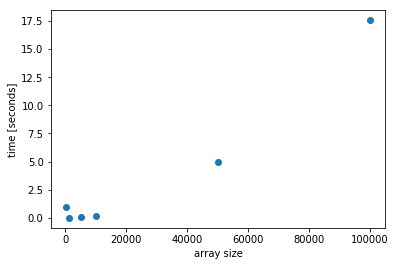

In [24]:
x,y=zip(*numba_reslt_dict.items())
plt.scatter(x,y)
plt.ylabel('time [seconds]')
plt.xlabel('array size')
plt.show()

In [27]:
z = np.polyfit(x, y, 2)

In [28]:
f = np.poly1d(z)
print(f)

           2
1.647e-09 x + 8.852e-06 x + 0.2419


In [29]:
x_new = np.linspace(0, 100000, 50)
y_new = f(x_new)

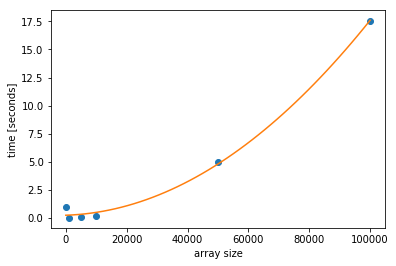

In [30]:
_=plt.plot(x,y,'o', x_new, y_new)
_=plt.ylabel('time [seconds]')
_=plt.xlabel('array size')

In [31]:
2*(2.092e-09)

4.184e-09

In [32]:
x=18000000 # array size
print((2.092e-09*x*x) - (5.401e-06*x) + 0.01703,'seconds')

677710.7990299999 seconds


677710.7990299999 seconds = 8 days

In [33]:
x=30000 # array size
print((2.092e-09*x*x) - (5.401e-06*x) + 0.01703,'seconds')

1.7377999999999998 seconds
